In [1]:
from curves import bsr_volatility
import numpy as np
import matplotlib.pyplot as plt

### Plot instantaneous volatility at t and tau
Note that instantanous volatility at tau is the integral over the instantanous curve from T to tau.

0.05372754469670032

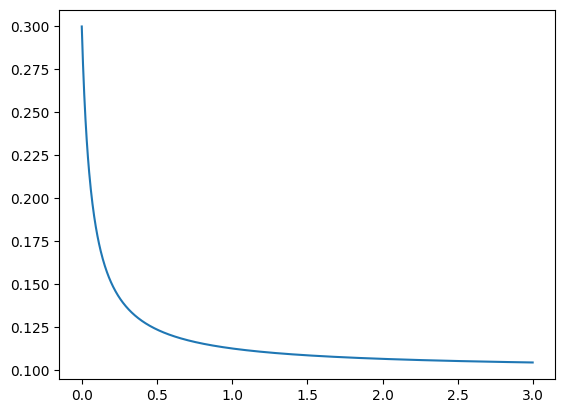

In [2]:

t = 0
T = 3
tau =1/12
dt = 1/365
#n_steps = int(T / dt)

b = 2/3/10
a = 0.2*b
c = 0.1

times_tau = np.arange(tau, T, dt) 
times_t = np.arange(t, T, dt) 

vol_tau = bsr_volatility.sigma_brs(t, tau, times_tau, a,b,c)

vol_inst = bsr_volatility.sigma_instantanous(t, times_t, a, b, c)


plt.plot(times_t, vol_inst)
#plt.plot(times_tau, vol_tau)
#plt.plot(times_tau, plugin_T1equalT2)

# Integral of variance instantanous equal to vol_tau.
np.sqrt(sum(vol_inst[0:7]**2)/7)
vol_tau[0]**2 # vol = 0.2760, var = 0.07618969



## Test plugin-volatility
Testing that Black'76 plug-in volatility is equal to instantaneous volatility for small tau and small (T2-T1)

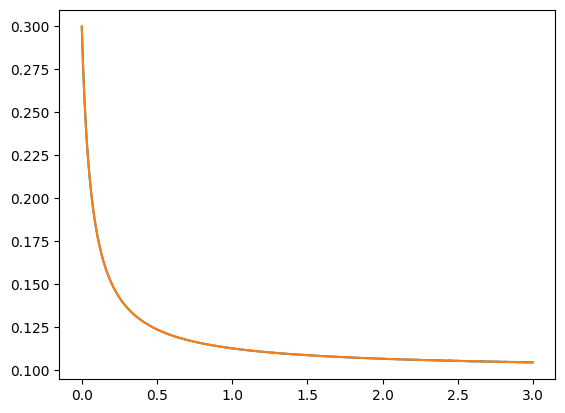

In [3]:
b = 2/3/10
a = 0.2*b
c = 0.1

T = 3
t = 0
T1 = 0.1
T2 = 0.100001
tau = 0.000001


times_tau = np.arange(tau, T, dt) 

ve= bsr_volatility.sigma_plugin(t,tau, times_tau, times_tau+0.0001, a, b,c)
plt.plot(times_tau, ve)
plt.plot(times_t, vol_inst)


### Display Plugin volatility 

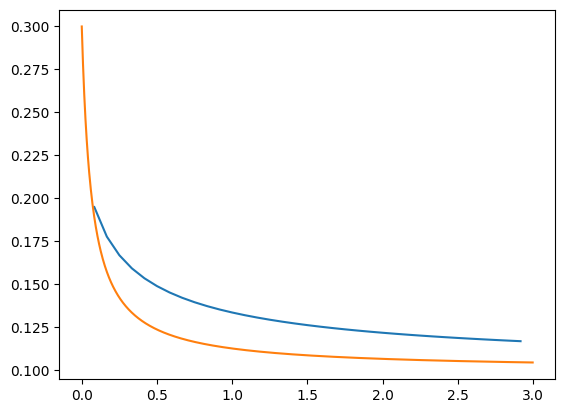

In [4]:
b = 2/3/10
a = 0.2*b
c = 0.1

T = 3
t = 0
tau = 1/12


times_tau = np.arange(tau, T, tau) 

ve= bsr_volatility.sigma_plugin(t,times_tau, times_tau, times_tau+tau, a, b,c)
plt.plot(times_tau, ve)
plt.plot(times_t, vol_inst)



### Test consistency between total volatility and the 3 factors

In [5]:

t = 0
T = 1 
tau =1/12

a= 0.9
b = 0.6
c= 0.1
    
vol = bsr_volatility.sigma_brs(t, tau, T, a,b,c)

print("volatility:"+ str(vol))
print("Variance:"+ str(vol**2))

f1 = bsr_volatility.sigma_factor1(t, tau, T, a,b)
f2 = bsr_volatility.sigma_factor2(t, tau, T, a,b,c)
f3 = bsr_volatility.sigma_factor3(t, tau, T, c)

print("SumVariance: "+ str((f1**2+f2**2+f3**2)))

volatility:0.6777365035803672
Variance:0.4593267682853411
SumVariance: 0.45932676828534064


## Simulation

### One factor

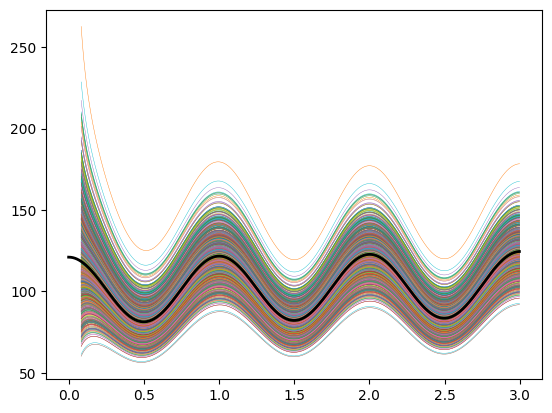

In [6]:
# Parameters 

n_sims = 1000  # Number of paths to simulate
T = 3  # Total time in years
dt = 1/365  # Daily time step
#n_steps = int(T / dt)
tau = 1/12


b = 2/3/10
a = 0.2*b
c = 0.1

times = np.arange(0, T, dt)   # Time steps
times_tau = np.arange(tau, T, dt) 

# Generate independent random samples
w = np.random.randn(n_sims, 1)

term_structure_initial = bsr_volatility.term_structure(times)
term_structure_tau = bsr_volatility.term_structure(times_tau)

#sigma = 0.3
vol_tau = bsr_volatility.sigma_brs(t, tau, times_tau, a,b,c)

z = np.exp(vol_tau * w - 0.5 * vol_tau**2*tau) 

sim_curves = z *  term_structure_tau

# Plot each row as a separate line
for i, row in enumerate(sim_curves):
    plt.plot(times_tau,row, label=f'Row {i+1}', lw=0.3)
    
plt.plot(times,term_structure_initial, color='black', lw=2, label='Term Structure')
#plt.plot(times,sigma_brs(t, t+dt, taus, a,b,c), color='black', lw=2, label='Term Structure')


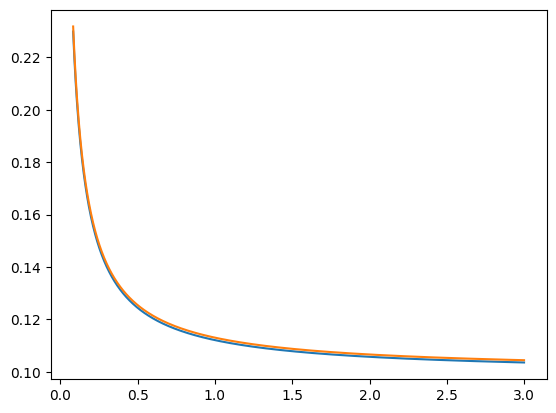

In [7]:
returns = np.log(z)
std_return = np.std(returns, axis = 0) 

plt.plot(times_tau, std_return)
plt.plot(times_tau, vol_tau)

## 3-Factor BSR (HJM) Simulation

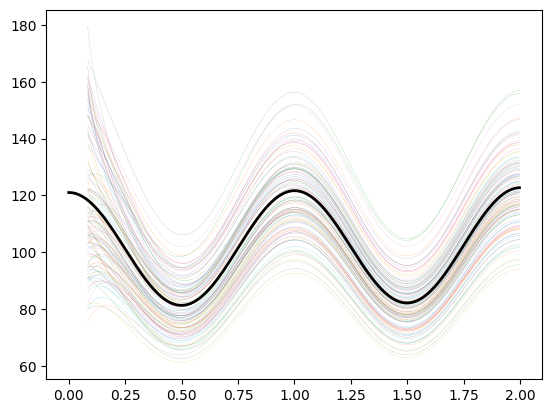

In [17]:
# Parameters 

n_sims = 100  # Number of paths to simulate
T = 2  # Total time in years
dt = 1/365  # Daily time step
#n_steps = int(T / dt)
tau = 1/12

b = 2/3/10
a = 0.2*b
c = 0.1

times = np.arange(0, T, dt)   # Time steps
times_tau = np.arange(tau, T, dt) 

vol_tau = bsr_volatility.sigma_brs(t, tau, times_tau, a,b,c)

# Generate independent random samples
w = np.random.randn(n_sims, 3)

term_structure_initial = bsr_volatility.term_structure(times)
term_structure_tau = bsr_volatility.term_structure(times_tau)

f1 = bsr_volatility.sigma_factor1(t, tau, times_tau, a,b)
f2 = bsr_volatility.sigma_factor2(t, tau, times_tau, a,b,c)
f3 = bsr_volatility.sigma_factor3(t, tau, times_tau, c)

z1 = np.exp(np.outer(w[:,0],f1) - 0.5 * f1**2*tau) 
z2 = np.exp(np.outer(w[:,1],f2) - 0.5 * f2**2*tau) 
z3 = np.exp(np.outer(w[:,2],f3) - 0.5 * f3**2*tau) 
Z = z1*z2*z3

sim_curves = Z *  term_structure_tau

# Plot each row as a separate line
for i, row in enumerate(sim_curves):
    plt.plot(times_tau,row, label=f'Row {i+1}', lw = 0.1)
    
plt.plot(times,term_structure_initial, color='black', lw=2, label='Term Structure')
#plt.plot(times,sigma_brs(t, t+dt, taus, a,b,c), color='black', lw=2, label='Term Structure')



### Check 3-factor simulation consistency
Note that it needs 10000 simulation to fit volatility accurately

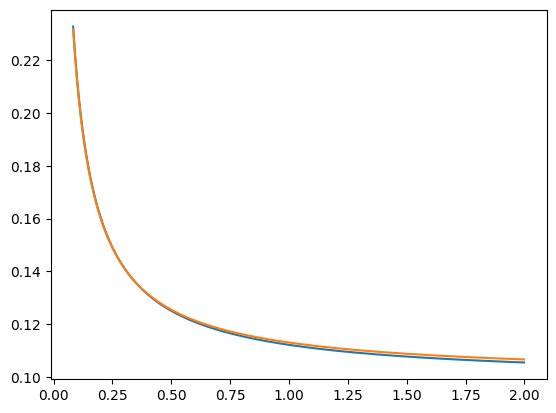

In [15]:
f_returns = np.log(Z)
std_sim_f_returns = np.std(f_returns, axis = 0) 

plt.plot(times_tau, std_sim_f_returns)
plt.plot(times_tau, vol_tau)



## Cashflow at Risk

### Volatility structure at each forward step
It is important to note that the spot volatility in the BSR framework is not constant, but a falling convex function of time.

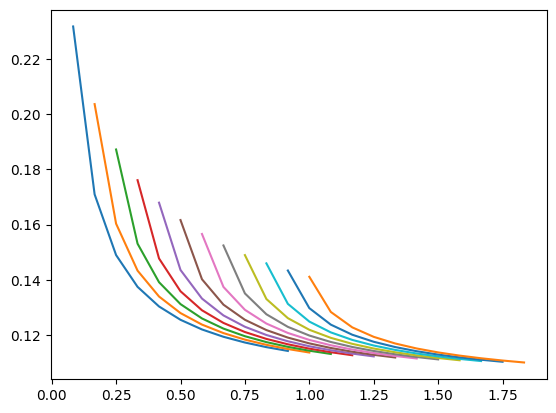

In [36]:
#sigma_brs (t, tau, T, a,b,c)
dt = 1/12
T = 1

b = 2/3/10
a = 0.2*b
c = 0.1

initial_times = np.arange(0, T, dt)   # Time steps

for i, t in enumerate(initial_times):
    step_times = initial_times + t
    sigma = bsr_volatility.sigma_brs(0, t+dt, step_times, a,b,c)
    plt.plot(step_times, sigma)


